In [3]:
import matplotlib.pyplot as plt
from ipywidgets import *
import numpy as np
import sys

In [4]:
import taurex.log
from taurex.cache import OpacityCache,CIACache
from taurex.temperature import Guillot2010
from taurex.planet import Planet
from taurex.stellar import BlackbodyStar
from taurex.chemistry import TaurexChemistry
from taurex.chemistry import ConstantGas
from taurex.model import TransmissionModel
from taurex.contributions import AbsorptionContribution
from taurex.contributions import CIAContribution
from taurex.contributions import RayleighContribution
from taurex.binning import FluxBinner,SimpleBinner


guillot = Guillot2010(T_irr=1200.0)
taurex.log.disableLogging()

Numba not installed, using numpy instead


In [5]:
OpacityCache().clear_cache()
OpacityCache().set_opacity_path("xsecs")
CIACache().set_cia_path("cia/hitran")

In [6]:
planet = Planet(planet_radius=0.97,planet_mass=0.62)
star = BlackbodyStar(temperature=5290.0,radius=0.99)

In [7]:
chemistry = TaurexChemistry(fill_gases=['H2','He'],ratio=0.172)
h2o = ConstantGas('H2O',mix_ratio=1.2e-2)
chemistry.addGas(h2o)
ch4 = ConstantGas('CH4',mix_ratio=1.2e-4)
chemistry.addGas(ch4)
co2 = ConstantGas('CO2',mix_ratio=1.2e-6)
chemistry.addGas(co2)
co = ConstantGas('CO',mix_ratio=1.2e-8)
chemistry.addGas(co)

In [8]:
tm = TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry,
                       star=star,
                        atm_min_pressure=1e-0,
                       atm_max_pressure=1e6,
                       nlayers=30)

In [9]:
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-H2','H2-He']))
tm.add_contribution(RayleighContribution())

In [10]:
tm.build()
res = tm.model()
res



(array([  199.99326855,   200.00660143,   200.01993521, ...,
        33328.88933329, 33331.11125925, 33333.33333333], shape=(76744,)),
 array([0.01044329, 0.01044329, 0.01044334, ..., 0.01071554, 0.01071556,
        0.01071559], shape=(76744,)),
 array([[2.13317016e-286, 1.98572134e-286, 1.84672159e-286, ...,
         1.13535245e-006, 1.13535245e-006, 1.13535245e-006],
        [5.73902140e-115, 5.57658485e-115, 5.41598205e-115, ...,
         1.68307951e-147, 1.52782550e-147, 1.38685212e-147],
        [2.20840977e-046, 2.18300901e-046, 2.15712405e-046, ...,
         4.65430494e-093, 4.37779437e-093, 4.11763486e-093],
        ...,
        [9.99999984e-001, 9.99999985e-001, 9.99999984e-001, ...,
         9.97864114e-001, 9.97863493e-001, 9.97862872e-001],
        [9.99999994e-001, 9.99999994e-001, 9.99999994e-001, ...,
         9.98812382e-001, 9.98812037e-001, 9.98811691e-001],
        [9.99999998e-001, 9.99999998e-001, 9.99999998e-001, ...,
         9.99486387e-001, 9.99486237e-001, 9.9

In [9]:
#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))
errorbars = np.full_like (bin_rprs,0.00001)

Data = np.zeros((len(bin_wn),3))
Data [:,0] = 10000/bin_wn
Data [:,1] = bin_rprs
Data [:,2] = errorbars
output_df = np.savetxt ('XO-2Nb_assignment3_taskA_spectrum.dat', Data, header='Wavelength(micron) (rp/rs)^2 Error_bars')

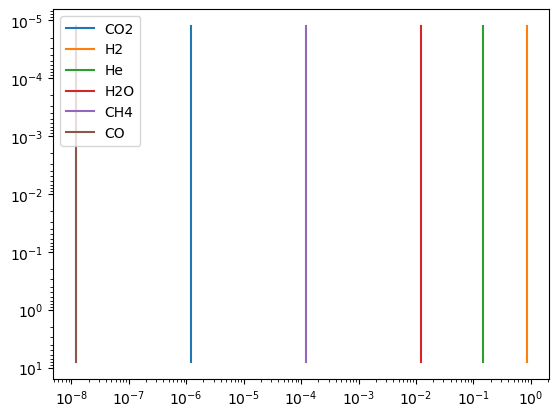

In [10]:
plt.figure()

for x,gasname in enumerate(tm.chemistry.activeGases):
    
    plt.plot(tm.chemistry.activeGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
for x,gasname in enumerate(tm.chemistry.inactiveGases):
    
    plt.plot(tm.chemistry.inactiveGasMixProfile[x],tm.pressureProfile/1e5,label=gasname)
plt.gca().invert_yaxis()
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

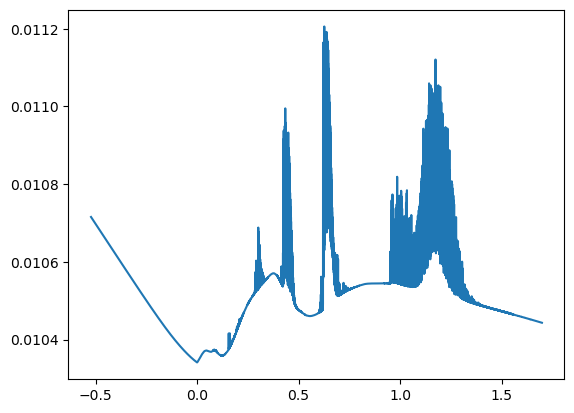

In [11]:
native_grid, rprs, tau, _ = res

full_fig = plt.figure()
plt.plot(np.log10(10000/native_grid),rprs)
plt.show()

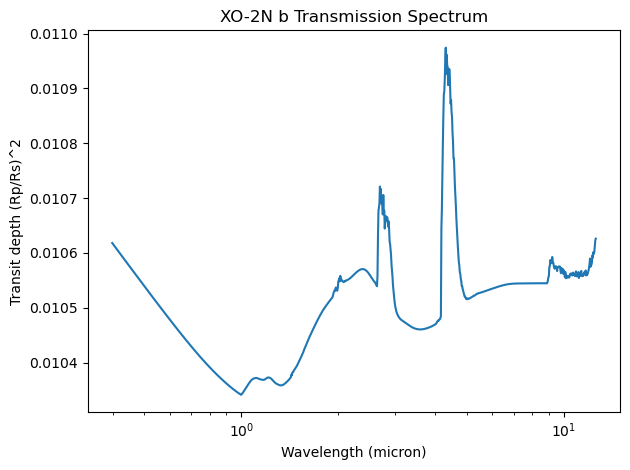

In [12]:
#task A
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale("log")
plt.xlabel("Wavelength (micron)")
plt.ylabel("Transit depth (Rp/Rs)^2")
plt.title("XO-2N b Transmission Spectrum")
plt.tight_layout()

plt.savefig("XO-2Nb_assignment3_taskA_spectrum.png", dpi=300)
plt.show()


In [13]:
#task A
# --- Task A: gas abundances (randomised or fixed) ---
h2o_ab = 1.2e-2
ch4_ab = 1.2e-4
co2_ab = 1.2e-6
co_ab  = 1.2e-8

with open("XO-2Nb_assignment3_taskA_parameters.txt", "w") as f:
    f.write("Planet: XO-2N b\n")
    f.write("Model: TauREx Transmission Spectrum\n\n")

    f.write("Planet parameters:\n")
    f.write("  Radius: 0.97 Rj\n")
    f.write("  Mass:   0.62 Mj\n\n")

    f.write("Star parameters:\n")
    f.write("  Temperature: 5290 K\n")
    f.write("  Radius:      0.99 Rsun\n\n")

    f.write("Atmosphere:\n")
    f.write(f"  H2O: {h2o_ab:.2e}\n")
    f.write(f"  CH4: {ch4_ab:.2e}\n")
    f.write(f"  CO2: {co2_ab:.2e}\n")
    f.write(f"  CO:  {co_ab:.2e}\n\n")

    f.write("Error model:\n")
    f.write("  Constant 10 ppm\n")


In [14]:
import numpy as np
import pandas as pd

# Load downloaded NASA Exoplanet Archive data
df = pd.read_csv("table_XO-2-N-b-Crouzet-et-al.-2012.tbl")


In [15]:
from astropy.table import Table

t = Table.read("table_XO-2-N-b-Crouzet-et-al.-2012.tbl", format="ipac")
t.colnames


['CENTRALWAVELNG',
 'BANDWIDTH',
 'PL_TRANDEP',
 'PL_TRANDEPERR1',
 'PL_TRANDEPERR2',
 'PL_TRANDEP_AUTHORS',
 'PL_RATROR',
 'PL_RATRORERR1',
 'PL_RATRORERR2',
 'PL_RATROR_AUTHORS',
 'PL_RADJ',
 'PL_RADJERR1',
 'PL_RADJERR2',
 'PL_RADJ_AUTHORS',
 'PL_TRANMID',
 'PL_TRANMIDERR1',
 'PL_TRANMIDERR2',
 'ST_RAD',
 'ST_RADERR1',
 'ST_RADERR2',
 'ST_RAD_AUTHORS']

In [16]:
wavelength = t["CENTRALWAVELNG"]          # microns
depth = t["PL_TRANDEP"]                  # (Rp/Rs)^2
error = 0.5 * (t["PL_TRANDEPERR1"] + t["PL_TRANDEPERR2"])  # symmetric erro             # + error
# Stack columns
spectrum = np.column_stack([wavelength, depth, error])

# Save Task B file
np.savetxt(
    "XO-2Nb_spectrum_assignment3_taskB.dat",
    spectrum,
    header="wavelength_micron  transit_depth_(Rp/Rs)^2  error",
)

print("Task B spectrum file created.")


Task B spectrum file created.


/root/anaconda3/envs/comp_astro_25/lib/python3.10/site-packages/taurex/util/util.py:379: RuntimeWarning: invalid value encountered in divide
  np.histogram(original_bin, filter_lhs, weights=original_data)[0]


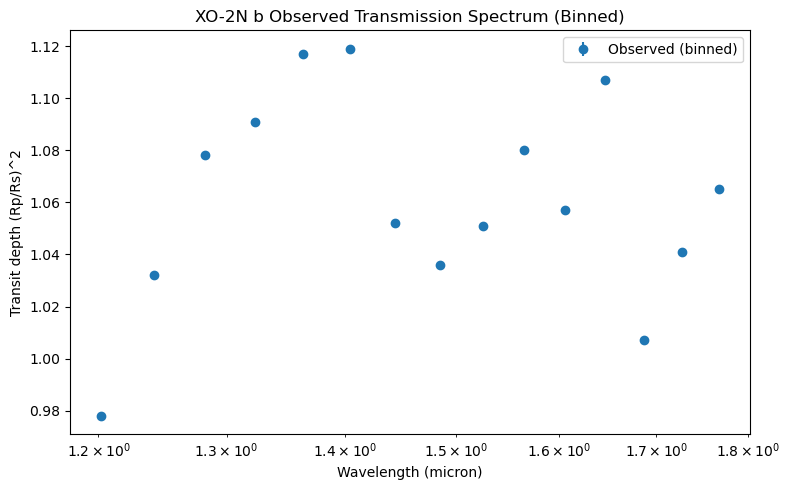

In [17]:
from taurex.data.spectrum.observed import ObservedSpectrum
import numpy as np
import matplotlib.pyplot as plt
from taurex.binning import SimpleBinner

# Load observed spectrum (Task B file)
obs = ObservedSpectrum("XO-2Nb_spectrum_assignment3_taskB.dat")

# Make a wavelength grid (microns → wavenumber)
wngrid = np.sort(10000 / np.linspace(1, 5, 100))  # cm^-1

# Bin the observed spectrum
bn = SimpleBinner(wngrid=wngrid)

bin_obs = bn.bindown(obs.wavenumberGrid, obs.spectrum)
errorbars = bn.bindown(obs.wavenumberGrid, obs.errorBar)

# Plot binned observed spectrum
plt.figure(figsize=(8, 5))
plt.errorbar(
    1e4 / wngrid,          # back to microns
    bin_obs[1],
    yerr=errorbars[1],
    fmt="o",
    label="Observed (binned)"
)

plt.xscale("log")
plt.xlabel("Wavelength (micron)")
plt.ylabel("Transit depth (Rp/Rs)^2")
plt.title("XO-2N b Observed Transmission Spectrum (Binned)")
plt.legend()
plt.tight_layout()

plt.savefig("XO-2Nb_spectrum_assignment3.png", dpi=300)
plt.show()


## Task C – Atmospheric retrieval of synthetic spectrum


In [18]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T_irr',
 'kappa_irr',
 'kappa_v1',
 'kappa_v2',
 'alpha',
 'T_int_guillot',
 'H2O',
 'CH4',
 'CO2',
 'CO',
 'He_H2']

In [19]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum('XO-2Nb_assignment3_taskA_spectrum.dat')


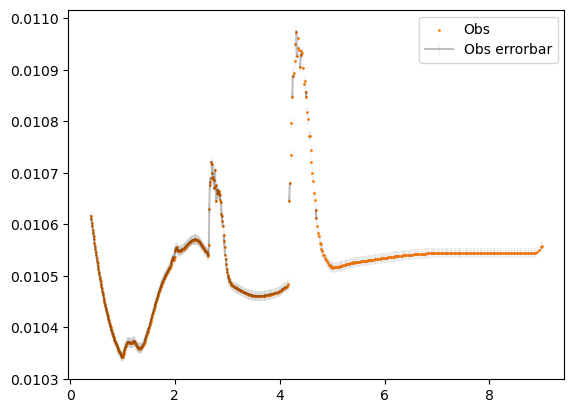

In [20]:
from taurex.data.spectrum.observed import ObservedSpectrum
import numpy as np
from taurex.binning import SimpleBinner,FluxBinner

obs = ObservedSpectrum('XO-2Nb_assignment3_taskA_spectrum.dat')
wngrid = np.sort(10000/np.linspace(0.3,9,1050))
bn = SimpleBinner(wngrid=wngrid)


bin_obs= bn.bindown(obs.wavenumberGrid, obs.spectrum)
errorbars = bn.bindown(obs.wavenumberGrid, obs.errorBar)


plt.figure()
plt.scatter(1e4/wngrid, bin_obs[1], label='Obs', c='C1', s=1)
plt.errorbar(1e4/wngrid, bin_obs[1], yerr=errorbars[1], label='Obs errorbar',color='k',markersize=2,alpha=0.25,elinewidth=0.25)

plt.legend()
plt.show()

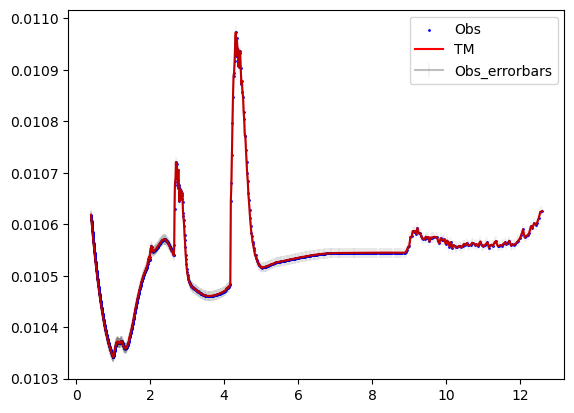

In [21]:
obin = obs.create_binner()
plt.figure()
plt.scatter(obs.wavelengthGrid, obs.spectrum, label='Obs', c='b', s=1)
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs_errorbars',c='k',markersize=2,alpha=0.25,elinewidth=0.25)
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM', c='r')
plt.legend()
plt.show()

In [22]:
from taurex.optimizer.nestle import NestleOptimizer

opt = NestleOptimizer(num_live_points=50)

#Setting up the model and observed spectrum for the optimizer
opt.set_model(tm)
opt.set_observed(obs)

#Set up which parameters to fit and their boundaries
opt.enable_fit('planet_radius')
opt.enable_fit('T_irr')
opt.enable_fit('H2O')
# opt.enable_fit('CH4')
# opt.enable_fit('CO2')
# opt.enable_fit('CO')
opt.set_boundary('T_irr',[900,2000])
opt.set_boundary('planet_radius',[0.9,1.5])
opt.set_boundary('H2O',[1e-8,1e-2])

In [23]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T_irr',
 'kappa_irr',
 'kappa_v1',
 'kappa_v2',
 'alpha',
 'T_int_guillot',
 'H2O',
 'CH4',
 'CO2',
 'CO',
 'He_H2']

In [24]:
fit_output = opt.fit()
taurex.log.disableLogging()

it=  1277 logz=10537.818260961564niter: 1278
ncall: 2455
nsamples: 1328
logz: 10538.113 +/-  0.669
h: 22.371


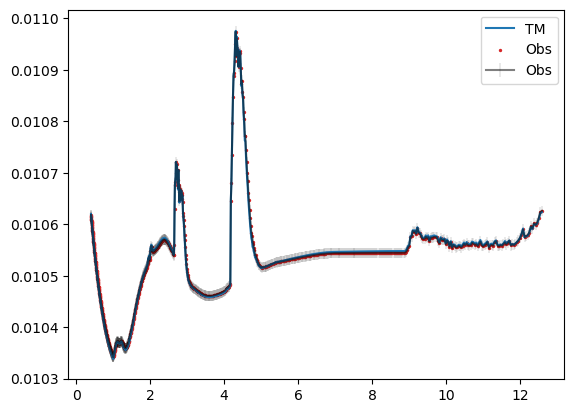

In [25]:
for fit_output,optimized_map,optimized_value,values in opt.get_solution():
    opt.update_model(optimized_map)
    ax = plt.figure()
    plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs',color='k',markersize=2,alpha=0.5,elinewidth=0.25)
    plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
    plt.scatter(obs.wavelengthGrid, obs.spectrum, label='Obs', c='C3', s=2)
    plt.legend()
    plt.show()
ax.savefig('assignment3_taskC.png')

In [26]:
output_file = 'assignment3_taskC.txt'

# Open file to write results
with open(output_file, 'w') as f:
    # Save Input (Fixed) Parameters
    f.write("================ INPUT / FIXED PARAMETERS ================\n")
    f.write(f"Planet Mass:     {tm.planet.mass}\n")
    f.write(f"Star Temperature:{tm.star.temperature}\n")
    f.write(f"Star Radius:     {tm.star.radius}\n")
    f.write(f"Min Pressure:    {tm.pressure.profile[-1]}\n")
    f.write(f"Max Pressure:    {tm.pressure.profile[0]}\n")
    f.write(f"Num Layers:      {tm.nLayers}\n")
    f.write("\n")

    # Save Retrieved Parameters with Error Bars
    f.write("================ RETRIEVED PARAMETERS ================\n")
    f.write(f"{'Parameter':<20} {'Median':<15} {'+1sigma':<15} {'-1sigma':<15} {'Best-Fit (Map)':<15}\n")
    f.write("-" * 85 + "\n")

    # Iterate through the solution
    for sol_idx, map, median, extra in opt.get_solution():
        
        # Update model with best fit parameters for the plot later
        opt.update_model(map)

        samples = opt.get_samples(sol_idx)
        param_names = opt.fit_names

        for i, name in enumerate(param_names):
            s = samples[:, i]
            
            # Calculate 16th, 50th (Median), and 84th percentiles
            q16, q50, q84 = np.percentile(s, [16, 50, 84])
            
            sigma_plus = q84 - q50
            sigma_minus = q50 - q16
            best_fit_val = median[i]

            # Write formatted line to file
            f.write(f"{name:<20} {q50:<15.5e} {sigma_plus:<15.5e} {sigma_minus:<15.5e} {best_fit_val:<15.5e}\n")

Task D

In [27]:
'''from astropy.table import Table
t = Table.read("table_XO-2-N-b-Crouzet-et-al.-2012.tbl", format="ipac")
t["CENTRALWAVELNG", "PL_TRANDEP", "PL_TRANDEPERR1"].write(
    "XO2Nb_real_spectrum.dat",
    format= "ascii.no_header",
    overwrite=True)'''

'from astropy.table import Table\nt = Table.read("table_XO-2-N-b-Crouzet-et-al.-2012.tbl", format="ipac")\nt["CENTRALWAVELNG", "PL_TRANDEP", "PL_TRANDEPERR1"].write(\n    "XO2Nb_real_spectrum.dat",\n    format= "ascii.no_header",\n    overwrite=True)'

In [19]:
from taurex.data.spectrum.observed import ObservedSpectrum
obs = ObservedSpectrum('XO2Nb_real_spectrum.dat')

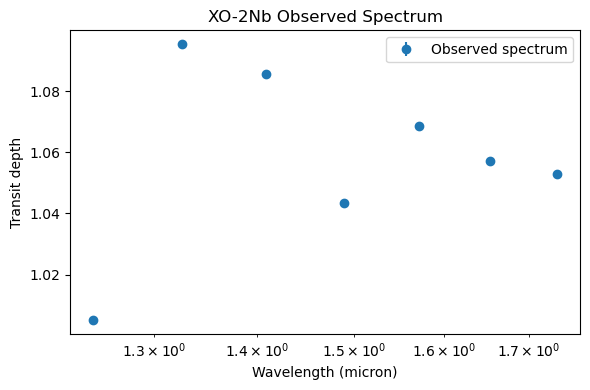

'\'from taurex.data.spectrum.observed import ObservedSpectrum\nfrom taurex.binning import SimpleBinner\n\nobs = ObservedSpectrum(\'XO-2Nb_spectrum_assignment3_taskB.dat\')\n#Make a logarithmic grid or a linear in the wavelength\nwngrid = np.sort(10000/np.linspace(1,5,50))\nbn = SimpleBinner(wngrid=wngrid)\n#chnages\n# FORCE non-zero uncertainties\nobs.errorBar[:] = np.maximum(obs.errorBar, 1e-5)  # 10 ppm everywhere\n# Safety check\nassert np.all(np.isfinite(obs.errorBar))\nassert np.all(obs.errorBar > 0)\n\n#errorbars = bn.bindown(obs.wavenumberGrid, obs.errorBar)\nobin = obs.create_binner()\nplt.figure()\nplt.errorbar(1e5/wngrid, bin_obs[1],yerr=errorbars[1], label=\'Obs\')\n#plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label=\'TM\')\nplt.legend()\nplt.show()\nplt.xlabel("wavelength (microns)")\nplt.ylabel("Transit Depth")\nplt.title("XO-2Nb Spectrum")'

In [21]:
from taurex.data.spectrum.observed import ObservedSpectrum
from taurex.binning import SimpleBinner
import numpy as np
import matplotlib.pyplot as plt

# Load observed (synthetic) spectrum
obs = ObservedSpectrum("XO2Nb_real_spectrum.dat")

# FORCE valid, non-zero uncertainties (critical)
obs.errorBar[:] = np.maximum(obs.errorBar, 1e-5)

# Safety checks
assert np.all(np.isfinite(obs.errorBar)), "Non-finite error bars detected"
assert np.all(obs.errorBar > 0), "Zero or negative error bars detected"

# Create wavelength grid for plotting (50 points)
wngrid = np.sort(10000 / np.linspace(1, 5, 50))

# Create binner
bn = SimpleBinner(wngrid=wngrid)

# IMPORTANT: bindown returns FOUR values
bin_wn, bin_flux, _, _ = bn.bindown(obs.wavenumberGrid, obs.spectrum)

# Plot binned observed spectrum
plt.figure(figsize=(6,4))
plt.errorbar(
    10000 / bin_wn,   # wavelength in microns
    bin_flux,         # transit depth
    yerr=1e-5,        # constant 10 ppm error bars
    fmt='o',
    label='Observed spectrum'
)
plt.xscale("log")
plt.xlabel("Wavelength (micron)")
plt.ylabel("Transit depth")
plt.title("XO-2Nb Observed Spectrum")
plt.legend()
plt.tight_layout()
plt.show()


''''from taurex.data.spectrum.observed import ObservedSpectrum
from taurex.binning import SimpleBinner

obs = ObservedSpectrum('XO-2Nb_spectrum_assignment3_taskB.dat')
#Make a logarithmic grid or a linear in the wavelength
wngrid = np.sort(10000/np.linspace(1,5,50))
bn = SimpleBinner(wngrid=wngrid)
#chnages
# FORCE non-zero uncertainties
obs.errorBar[:] = np.maximum(obs.errorBar, 1e-5)  # 10 ppm everywhere
# Safety check
assert np.all(np.isfinite(obs.errorBar))
assert np.all(obs.errorBar > 0)

#errorbars = bn.bindown(obs.wavenumberGrid, obs.errorBar)
obin = obs.create_binner()
plt.figure()
plt.errorbar(1e5/wngrid, bin_obs[1],yerr=errorbars[1], label='Obs')
#plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(obs.wavenumberGrid))[1],label='TM')
plt.legend()
plt.show()
plt.xlabel("wavelength (microns)")
plt.ylabel("Transit Depth")
plt.title("XO-2Nb Spectrum")'''

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

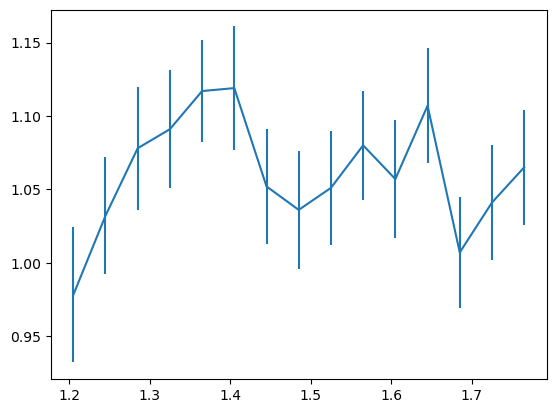

In [32]:
'''from taurex.data.spectrum.observed import ObservedSpectrum
import matplotlib.pyplot as plt
import numpy as np

# Build model (already correct in your notebook)
tm.build()

# Run model on observed grid
model_res = tm.model(wngrid=obs.wavenumberGrid)

# Create binner from observed spectrum
obin = obs.create_binner()

# IMPORTANT: unpack bin_model output
bin_wn, bin_flux, _, _ = obin.bin_model(model_res)

# Plot
plt.figure(figsize=(6,4))

# Observed spectrum
plt.errorbar(
    obs.wavelengthGrid,
    obs.spectrum,
    yerr=obs.errorBar,
    fmt='o',
    label='Observed'
)

# Model spectrum (binned to observation grid)
plt.plot(10000 / bin_wn, bin_flux**2, label='Model')


plt.xscale("log")
plt.xlabel("Wavelength (micron)")
plt.ylabel("Transit depth")
plt.title("XO-2Nb: Observed vs Model")
plt.legend()
plt.tight_layout()
plt.show()'''

chemistry2 = TaurexChemistry(fill_gases=['H2','He'],ratio=0.15)
rng = np.random.default_rng(seed=100)
chemistry2.addGas(ConstantGas('H2O',1e-5))
chemistry2.addGas(ConstantGas('SiO',1e-4))
chemistry2.addGas(ConstantGas('CO2',1e-5))
chemistry2.addGas(ConstantGas('CO',10e-2))
tm= TransmissionModel(planet=planet,
                       temperature_profile=guillot,
                       chemistry=chemistry2,
                       star=star,
                       atm_min_pressure=1e-0,
                       atm_max_pressure=1e10,
                       nlayers=30)
tm.add_contribution(AbsorptionContribution())
tm.add_contribution(CIAContribution(cia_pairs=['H2-He']))
tm.add_contribution(RayleighContribution())
tm.build()
res = tm.model()
obin = obs.create_binner()

plt.figure()
plt.errorbar(obs.wavelengthGrid,obs.spectrum,obs.errorBar,label='Obs')
plt.plot(obs.wavelengthGrid,obin.bin_model(tm.model(wngrid=obs.wavenumberGrid)))
plt.legend()
plt.show()

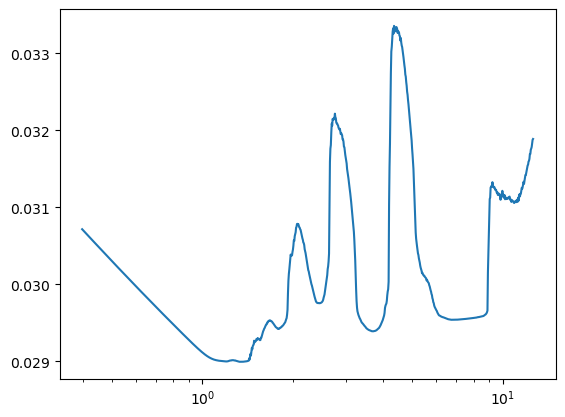

In [33]:
from taurex.binning import FluxBinner,SimpleBinner
binned_fig = plt.figure()


#Make a logarithmic grid
wngrid = np.sort(10000/np.logspace(-0.4,1.1,1000))
bn = SimpleBinner(wngrid=wngrid)

bin_wn, bin_rprs,_,_  = bn.bin_model(tm.model(wngrid=wngrid))

plt.plot(10000/bin_wn,bin_rprs)
plt.xscale('log')
plt.show()
# THIS IS WHAT MODEL LOOKS LIKE BEFORE FITTING... WHY NOT WORKING WHEN PLOTTING AGAINST OBS??????

In [34]:
list(tm.fittingParameters.keys())

['planet_mass',
 'planet_radius',
 'planet_distance',
 'planet_sma',
 'distance',
 'atm_min_pressure',
 'atm_max_pressure',
 'T_irr',
 'kappa_irr',
 'kappa_v1',
 'kappa_v2',
 'alpha',
 'T_int_guillot',
 'H2O',
 'SiO',
 'CO2',
 'CO',
 'He_H2']

In [35]:
from taurex.optimizer.nestle import NestleOptimizer

opt = NestleOptimizer(num_live_points=50)
opt.set_model(tm)
opt.set_observed(obs)
opt.enable_fit('planet_radius')
opt.enable_fit("T_irr")
opt.enable_fit("H2O")
opt.enable_fit("SiO")
opt.enable_fit("CO2")
opt.enable_fit("He_H2")
opt.set_boundary("H2O",[1e-5,1e-3])
opt.set_boundary('T_irr',[1500,2500])
opt.set_boundary('planet_radius',[0.7,1.5])

In [27]:
for gas in chemistry2.activeGases:
    print(
        gas
    )

In [36]:
#assert np.all(errorbars > 0), "ERROR: zero uncertainties detected" #changes
solution = opt.fit()
taurex.log.disableLogging()

it=   668 logz=-5113.498988niter: 669
ncall: 1259
nsamples: 719
logz: -5113.266 +/-  0.446
h:  9.937


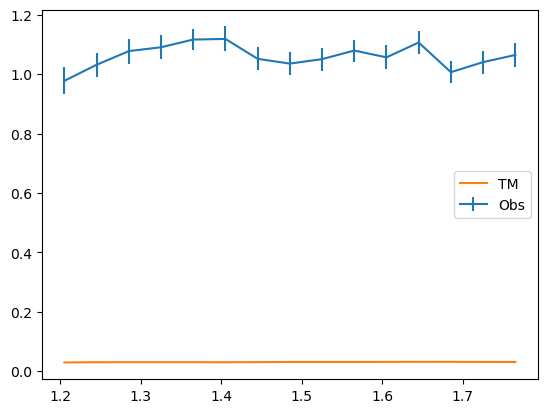

In [37]:
for solution, optimized_map, optimized_value, values in opt.get_solution():
    opt.update_model(optimized_map)

    # tm2.model returns just the spectrum
    spec = tm.model(obs.wavenumberGrid)

    # Bin it
    binned = obin.bin_model(spec)[1]

    # Plot
    plt.figure()
    plt.errorbar(obs.wavelengthGrid, obs.spectrum, obs.errorBar, label="Obs")
    plt.plot(obs.wavelengthGrid, binned, label="TM")
    plt.legend()
    plt.show()